Scirpy Tutorial from https://icbi-lab.github.io/scirpy-paper/wu2020.html

0. Setup

In [2]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.insert(0, "/Users/danhudson/opt/miniconda3/envs/scanpy")
import scirpy as ir
import pandas as pd
import numpy as np
import scanpy as sc
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib
from weblogo.seq import SeqList, unambiguous_protein_alphabet
from weblogo import png_formatter, svg_formatter, eps_formatter
from weblogo import LogoData, LogoOptions, LogoFormat
from IPython.display import Image, display
import warnings

sc.settings._vector_friendly = True

warnings.filterwarnings('ignore', category=FutureWarning)

# whether to run the alignment or use a cached version.
# If `False` and the cached version is not available, will raise an error.
run_alignment = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def weblogo(seqs, title="", format="png"):
    """Draw a sequence logo from a list of amino acid sequences. """
    logodata = LogoData.from_seqs(SeqList(seqs, alphabet=unambiguous_protein_alphabet))
    logooptions = LogoOptions(logo_title=title)
    logoformat = LogoFormat(logodata, logooptions)
    if format == "png":
        display(Image(png_formatter(logodata, logoformat)))
    elif format == "eps":
        return eps_formatter(logodata, logoformat)

In [4]:
# colors from the paper
colors = {
    "Tumor+NAT expanded": "#9458a2",
    "Tumor singleton": "#ff8000",
    "NAT singleton": "#f7f719",
    "Tumor multiplet": "#eeb3cb",
    "NAT multiplet": "#9cd0de",
    "Blood singleton": "#cce70b",
    "Blood multiplet": "#beac83",
}

1. Preparing the data

The dataset ships with the scirpy package. We can conveniently load it from the scirpy.datasets module.

In [12]:
adata = ir.datasets.wu2020()
adata

AnnData object with n_obs × n_vars = 141623 × 30727
    obs: 'cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'has_ir', 'batch', 'extra_chains'
    var: 'gene_ids', 'feature_types'
    uns: 'scirpy_version'
    obsm: 'X

In [10]:
adata.shape

(141623, 30727)

We only keep the cells with TCR. ~96k cells remain.

In [13]:
adata = adata[adata.obs["has_ir"] == "True", :]
adata = adata[~(adata.obs["cluster_orig"] == "nan"), :]
adata.shape

In [15]:
adata.obs.columns

Index(['cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig',
       'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus',
       'IR_VDJ_2_locus', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa',
       'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_junction_ins',
       'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins',
       'IR_VDJ_2_junction_ins', 'IR_VJ_1_duplicate_count',
       'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count',
       'IR_VDJ_2_duplicate_count', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call',
       'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'IR_VJ_1_d_call',
       'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call',
       'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call',
       'IR_VDJ_2_j_call', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call',
       'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_junction',
       'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'has_ir',
       'batch', 'extra_chains'],
      dtype='object')

In [23]:
adata.obs["counts"] = adata.X.sum(axis=1).A1
adata.obs["counts"].head()

RT2_AAACCTGAGGTAGCCA-1-0    5036.0
RT2_AAACCTGCAGGTCCAC-1-0    2512.0
RT2_AAACCTGCATCCGTGG-1-0    3238.0
RT2_AAACCTGCATCGTCGG-1-0    4250.0
RT2_AAACCTGTCTGAGTGT-1-0    3279.0
Name: counts, dtype: float32

Preprocess Transcriptomics data
Transcriptomics data needs to be filtered and preprocessed as with any other single-cell dataset. We recommend following the scanpy tutorial and the best practice paper by Luecken et al.. For the Wu et al. (2020) dataset, the authors already provide clusters and UMAP coordinates. Instead of performing clustering and cluster annotation ourselves, we will just use provided data. The clustering and annotation procedure used by the authors is described in their paper.

In [24]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=100)

In [25]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000)
sc.pp.log1p(adata)

In [26]:
adata.obsm["X_umap"] = adata.obsm["X_umap_orig"]

In [27]:
mapping = {
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
    "nan": "nan",
}
adata.obs["cluster"] = [mapping[x] for x in adata.obs["cluster_orig"]]

Let's inspect the UMAP plots. The first three panels show the UMAP plot colored by sample, patient and cluster. We don't observe any clustering of samples or patients that could hint at batch effects.

The last three panels show the UMAP colored by the T cell markers CD8, CD4, and FOXP3. We can confirm that the markers correspond to their respective cluster labels.

... storing 'cluster' as categorical


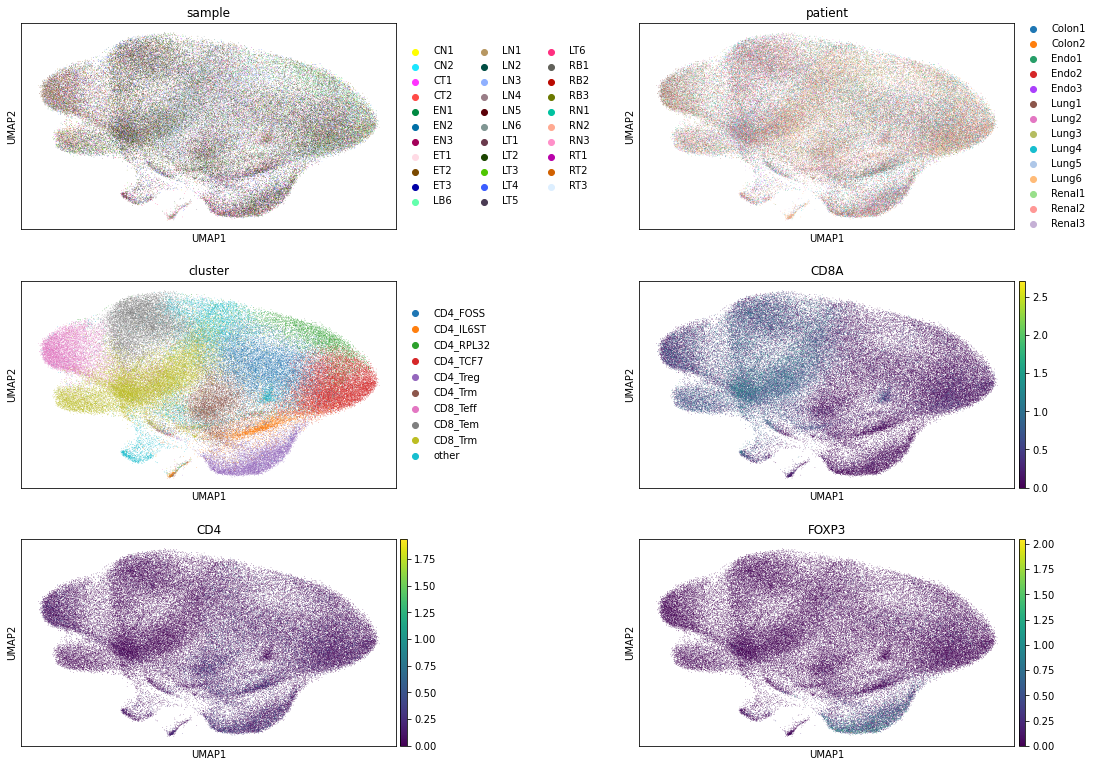

In [28]:
sc.pl.umap(
    adata,
    color=["sample", "patient", "cluster", "CD8A", "CD4", "FOXP3"],
    ncols=2,
    wspace=0.5,
)

TCR Quality Control
While most of T cell receptors have exactly one pair of α and β chains, up to one third of T cells can have dual TCRs, i.e. two pairs of receptors originating from different alleles (Schuldt et al (2019)).

Using the scirpy.tl.chain_pairing function, we can add a summary about the T cell receptor compositions to adata.obs.

Orphan chain refers to cells that have either a single alpha or beta receptor chain.
Extra chain refers to cells that have a full alpha/beta receptor pair, and an additional chain.
Multichain refers to cells with more than two receptor pairs detected. These cells are likely doublets.

In [29]:
%%time
ir.tl.chain_pairing(adata)

CPU times: user 329 ms, sys: 14.1 ms, total: 343 ms
Wall time: 350 ms


In [36]:
adata.obs

,cluster_orig,patient,sample,source,clonotype_orig,multi_chain,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,...,has_ir,batch,extra_chains,counts,n_genes,n_counts,cluster,receptor_type,receptor_subtype,chain_pairing
RT2_AAACCTGAGGTAGCCA-1-0,8.2-Tem,Renal2,RT2,Tumor,renal2.tnb.C1,False,TRA,nan,TRB,nan,...,True,0,NaN,5036.0,1753,5036.0,CD8_Tem,TCR,TRA+TRB,single pair
RT2_AAACCTGCAGGTCCAC-1-0,8.3b-Trm,Renal2,RT2,Tumor,renal2.tnb.C2,False,nan,nan,TRB,nan,...,True,0,NaN,2512.0,1077,2512.0,CD8_Trm,TCR,TRA+TRB,orphan VDJ
RT2_AAACCTGCATCCGTGG-1-0,8.3c-Trm,Renal2,RT2,Tumor,renal2.tnb.C1,False,TRA,nan,TRB,nan,...,True,0,NaN,3238.0,1338,3237.0,CD8_Trm,TCR,TRA+TRB,single pair
RT2_AAACCTGCATCGTCGG-1-0,4.3-TCF7,Renal2,RT2,Tumor,renal2.tnb.C3,False,TRA,nan,TRB,nan,...,True,0,NaN,4250.0,1351,4250.0,CD4_TCF7,TCR,TRA+TRB,single pair
RT2_AAACCTGTCTGAGTGT-1-0,4.1-Trm,Renal2,RT2,Tumor,renal2.tnb.C4,False,TRA,nan,TRB,nan,...,True,0,NaN,3279.0,1134,3279.0,CD4_Trm,TCR,TRA+TRB,single pair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CT2_TTTGCGCCACCGGAAA-1-31,8.3a-Trm,Colon2,CT2,Tumor,colon2.tn.C950,False,TRA,nan,TRB,nan,...,True,31,NaN,3134.0,1171,3134.0,CD8_Trm,TCR,TRA+TRB,single pair
CT2_TTTGGTTAGCCACGCT-1-31,8.3c-Trm,Colon2,CT2,Tumor,colon2.tn.C48,False,TRA,nan,TRB,nan,...,True,31,NaN,3484.0,1424,3483.0,CD8_Trm,TCR,TRA+TRB,single pair
CT2_TTTGGTTGTGCCTTGG-1-31,4.4-FOS,Colon2,CT2,Tumor,colon2.tn.C954,False,nan,nan,TRB,nan,...,True,31,NaN,1422.0,741,1421.0,CD4_FOSS,TCR,TRA+TRB,orphan VDJ
CT2_TTTGGTTTCACTTACT-1-31,4.3-TCF7,Colon2,CT2,Tumor,colon2.tn.C955,False,TRA,nan,TRB,nan,...,True,31,NaN,3528.0,1301,3528.0,CD4_TCF7,TCR,TRA+TRB,single pair


... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


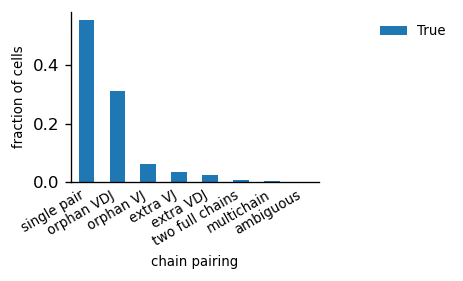

In [31]:
ax = ir.pl.group_abundance(
    adata, groupby="chain_pairing", target_col="has_ir", normalize="has_ir"
)
ax.set_ylabel("fraction of cells")
ax.set_xlabel("chain pairing")
ax.set_title("")
fig = ax.get_figure()
fig.savefig("figures/chain_pairing.svg")

In [37]:
list(set([x for x in adata.obs['chain_pairing']]))

['multichain',
 'extra VJ',
 'ambiguous',
 'single pair',
 'two full chains',
 'orphan VDJ',
 'orphan VJ',
 'extra VDJ']

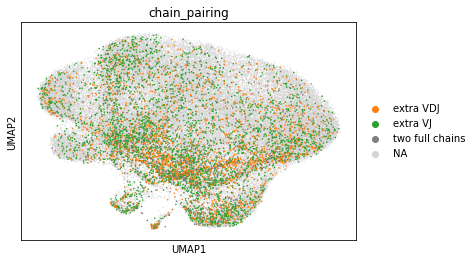

In [39]:
sc.pl.umap(
    adata,
    color="chain_pairing",
    groups=["extra VDJ", "extra VJ", "two full chains"],
    size=[
        10 if x in ["extra VDJ", "extra VJ", "two full chains"] else 3
        for x in adata.obs["chain_pairing"]
    ],
)

In [42]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["extra VDJ", "extra VJ", "two full chains"]
            )
        )
        / adata.n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07


Excluding multichain cells
Next, we visualize the Multichain cells on the UMAP plot and exclude them from downstream analysis. Multichain cells likely represent doublets. This is corroborated by the fact that they tend to have a very high number of detected transcripts.

In [43]:
_, pvalue = sp.stats.mannwhitneyu(
    adata.obs.loc[adata.obs["multi_chain"] == "True", "counts"].values,
    adata.obs.loc[adata.obs["multi_chain"] == "False", "counts"].values,
)

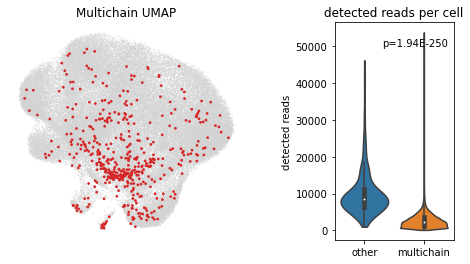

In [49]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 4), gridspec_kw={"width_ratios": [2, 1]}
)
sc.pl.umap(
    adata,
    color="chain_pairing",
    groups="multichain",
    size=[30 if x == "multichain" else 3 for x in adata.obs["chain_pairing"]],
    ax=ax1,
    legend_loc="none",
    show=False,
    frameon=False,
    title="Multichain UMAP",
)
sc.pl.violin(
    adata, "counts", "multi_chain", ax=ax2, show=False, inner="box", stripplot=False
)
ax2.set_ylabel("detected reads")
ax2.set_xlabel("")
ax2.set_xticklabels(["other", "multichain"])
ax2.set_title("detected reads per cell")
ax2.text(0.3, 50000, f"p={pvalue:.2E}")
plt.subplots_adjust(wspace=0.5)
fig.savefig("figures/multichains.svg", dpi=600)

In [50]:
print(
    f"Median counts Multichain: {np.median(adata.obs.loc[adata.obs['multi_chain'] == 'True', 'counts'].values)}"
)
print(
    f"Median counts other: {np.median(adata.obs.loc[adata.obs['multi_chain'] == 'False', 'counts'].values)}"
)

Median counts Multichain: 8517.5
Median counts other: 2301.0


In [51]:
adata.shape

(96063, 17691)

In [54]:
adata = adata[adata.obs["chain_pairing"] != "multichain", :].copy()
adata.shape

(95589, 17691)

2. Define clonotypes
Defining clonotypes in scirpy is a two-step procedure:

Computing a neighborhood graph based on CDR3 sequences
Finding connected submodules in the neighborhood graph and annotating them as clonotypes
scirpy provides several metrics for creating the neighborhood graph. For instance, it is possible to choose between using nucleotide or amino acid CDR3 sequences, or using a sequence similarity metric based on multiple sequence alignments instead of requiring sequences to be identical.

In [55]:
sc.settings.verbosity = 4

identical nucleotide sequences
The authors of the dataset define the clonotypes on the nucleotide sequences and require all sequences of both receptor arms (and multiple chains in case of dual TCRs) to match.

In [59]:
# Compute TCR distances with ir_dist

%%time
ir.pp.ir_dist(adata)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
CPU times: user 326 ms, sys: 33.4 ms, total: 360 ms
Wall time: 359 ms


In [62]:
%%time
ir.tl.define_clonotypes(adata, receptor_arms = 'all', dual_ir='all')

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:05)
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


100%|██████████| 54955/54955 [01:21<00:00, 675.22it/s]


--> Done computing clonotype x clonotype distances.  (0:01:24)
Stored clonal assignments in `adata.obs["clone_id"]`.
CPU times: user 1min 8s, sys: 4.81 s, total: 1min 13s
Wall time: 1min 30s


Identical amino acid sequences
Alternatively, we can define "clonotype clusters" based on identical amino acid sequences. Other than clonotypes, these do not necessarily arise from the same antecedent cell, but they recognize the same epitope.

In [63]:
%%time
ir.pp.ir_dist(
    adata, metric="identity", sequence="aa"
)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
CPU times: user 256 ms, sys: 12.4 ms, total: 268 ms
Wall time: 267 ms


In [64]:
%%time
ir.tl.define_clonotype_clusters(adata, receptor_arms = 'all', dual_ir='all',metric="identity", sequence="aa")

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:05)
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


100%|██████████| 54643/54643 [01:16<00:00, 710.93it/s] 


--> Done computing clonotype x clonotype distances.  (0:01:19)
Stored clonal assignments in `adata.obs["cc_aa_identity"]`.
CPU times: user 1min 5s, sys: 3.25 s, total: 1min 9s
Wall time: 1min 25s


similar amino acid sequences
With scirpy, it is possible to to one step further and summarize cells into the same clonotype cluster that might recognize the same epitope because they have similar amino acid sequences. This can be done by leveraging Levenshtein or alignment distances. Here, we compute the alignment distance with a cutoff of 15, which is equivalent of three As mutating into R

In [65]:
outfile="./data/scirpy_10X_adata_in.h5ad"
adata.write_h5ad(outfile)

... storing 'clone_id' as categorical
... storing 'cc_aa_identity' as categorical
